In [1]:
from flash_ansr import FlashANSR, GenerationConfig, install_model, get_path
 
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from drawdata import ScatterWidget

In [3]:
MODEL = "psaegert/flash-ansr-v19.1-26M"

In [4]:
install_model(MODEL)

Installing model psaegert/flash-ansr-v19.1-26M to /home/psaegert/Projects/flash-ansr/models/psaegert/flash-ansr-v19.1-26M


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Model psaegert/flash-ansr-v19.1-26M installed successfully!


In [5]:
nsr = FlashANSR.load(
    directory=get_path('models', MODEL),
    # generation_config=GenerationConfig(method='beam_search', beam_width=128 * 16, equivalence_pruning=True),
    generation_config=GenerationConfig(method='softmax_sampling', choices=1024 * 32, max_len=32),
    parsimony=0.02
).to(device)

In [6]:
widget = ScatterWidget()
widget

ScatterWidget()

In [7]:
X_raw, y_raw = widget.data_as_X_y

# Scale X_raw and y_raw to (-10, 10)
X = (X_raw - X_raw.min(axis=0)) / (X_raw.max(axis=0) - X_raw.min(axis=0)) * 20 - 10
y = (y_raw - y_raw.min(axis=0)) / (y_raw.max(axis=0) - y_raw.min(axis=0)) * 20 - 10

In [8]:
nsr.fit(X, y, verbose=True)

Fitting Constants: 100%|██████████| 4547/4547 [00:06<00:00, 740.77it/s] 


In [28]:
nsr.compile_results(parsimony=0.02)

In [29]:
nsr.get_expression()

'(cos((x1 / -5.32)) * (x1 - (-3.59 + abs(((-3.78 + x1) / 0.54)))))'

In [23]:
nsr.results

,log_prob,fvu,score,expression,complexity,target_complexity,numeric_prediction,raw_beam,beam,raw_beam_decoded,function,refiner,beam_id,fit_constants,fit_covariances,fit_loss
0,-10.976831,0.024047,-1.068932,"[*, -, <constant>, x1, sin, cos, -, <constant>...",11,None,None,"[1, 17, 16, 6, 47, 31, 32, 16, 6, 17, 6, 47, 2]","[17, 16, 6, 47, 31, 32, 16, 6, 17, 6, 47]","[*, -, <constant>, x1, sin, cos, -, <constant>...",<function <lambda> at 0x7a14ea1aad40>,"Refiner(expression=['*', '-', '<constant>', 'x...",0,"[8.83091725329673, -1.9028892002223323, -0.336...","[[0.020842112543598093, -0.0005209367795246935...",0.610052
1,-13.724828,0.027054,-0.967773,"[*, -, <constant>, x1, -, <constant>, cos, -, ...",12,None,None,"[1, 17, 16, 6, 47, 16, 6, 32, 16, 18, 47, 6, 6...","[17, 16, 6, 47, 16, 6, 32, 16, 18, 47, 6, 6]","[*, -, <constant>, x1, -, <constant>, cos, -, ...",<function <lambda> at 0x7a1500797ba0>,"Refiner(expression=['*', '-', '<constant>', 'x...",1,"[8.519187539752199, 0.10912929229231674, 3.152...","[[0.01922897840799054, 0.0011467646321116148, ...",0.686319
2,-21.867085,0.019452,-0.961034,"[*, cos, /, x1, <constant>, -, x1, +, <constan...",15,None,None,"[1, 17, 32, 18, 47, 6, 16, 47, 15, 6, 19, 18, ...","[17, 32, 18, 47, 6, 16, 47, 15, 6, 19, 18, 15,...","[*, cos, /, x1, <constant>, -, x1, +, <constan...",<function <lambda> at 0x7a14d43180e0>,"Refiner(expression=['*', 'cos', '/', 'x1', '<c...",2,"[-5.32466092157646, -3.587460980892885, -3.777...","[[0.00028887889545065385, 0.000298599866198342...",0.493474
3,-9.509065,0.035158,-0.953981,"[*, -, x1, <constant>, sin, /, -, x1, <constan...",10,None,None,"[1, 17, 16, 47, 6, 31, 18, 16, 47, 6, 6, 2]","[17, 16, 47, 6, 31, 18, 16, 47, 6, 6]","[*, -, x1, <constant>, sin, /, -, x1, <constan...",<function <lambda> at 0x7a14d4734400>,"Refiner(expression=['*', '-', 'x1', '<constant...",3,"[8.091546575347351, 0.937188750374038, -2.9497...","[[0.02480857252429836, 0.0029332521877201696, ...",0.891903
4,-6.916646,0.035158,-0.953981,"[*, +, <constant>, x1, cos, -, <constant>, /, ...",10,None,None,"[1, 17, 15, 6, 47, 32, 16, 6, 18, 47, 6, 2]","[17, 15, 6, 47, 32, 16, 6, 18, 47, 6]","[*, +, <constant>, x1, cos, -, <constant>, /, ...",<function <lambda> at 0x7a14d476c5e0>,"Refiner(expression=['*', '+', '<constant>', 'x...",4,"[-8.091546512819825, 5.030105652219291, 2.9497...","[[0.024808585398979472, -0.0008764315765583576...",0.891903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4542,-36.514256,NaN,NaN,"[*, <constant>, -, abs, +, -, <constant>, *, <...",17,None,None,"[1, 17, 6, 16, 19, 15, 16, 6, 17, 6, 47, 38, 1...","[17, 6, 16, 19, 15, 16, 6, 17, 6, 47, 38, 15, ...","[*, <constant>, -, abs, +, -, <constant>, *, <...",<function <lambda> at 0x7a14d41ebec0>,"Refiner(expression=['*', '<constant>', '-', 'a...",4542,"[-3.27996774441408, 3.321601217132514, 1.20725...","[[inf, inf, inf, inf, inf, inf], [inf, inf, in...",NaN
4543,-36.952278,NaN,NaN,"[*, <constant>, *, +, <constant>, x1, tan, *, ...",18,None,None,"[1, 17, 6, 17, 15, 6, 47, 33, 17, 6, 32, 30, 1...","[17, 6, 17, 15, 6, 47, 33, 17, 6, 32, 30, 15, ...","[*, <constant>, *, +, <constant>, x1, tan, *, ...",<function <lambda> at 0x7a14cc71c180>,"Refiner(expression=['*', '<constant>', '*', '+...",4543,[],[],NaN
4544,-37.105293,NaN,NaN,"[*, <constant>, *, exp, *, <constant>, exp, x1...",15,None,None,"[1, 17, 6, 17, 37, 17, 6, 37, 47, 34, 17, 6, 3...","[17, 6, 17, 37, 17, 6, 37, 47, 34, 17, 6, 32, ...","[*, <constant>, *, exp, *, <constant>, exp, x1...",<function <lambda> at 0x7a14cc71c400>,"Refiner(expression=['*', '<constant>', '*', 'e...",4544,"[-1.1371258941422302, 3.3889141905223106, -1.2...","[[inf, inf, inf, inf], [inf, inf, inf, inf], [...",NaN
4545,-38.780624,NaN,NaN,"[*, -, x1, <constant>, cos, pow1_2, -, <consta...",9,None,None,"[1, 17, 16, 47, 6, 32, 27, 16, 6, 47, 2]","[17, 16, 47, 6, 32, 27, 16, 6, 47]","[*, -, x1, <constant>, cos, pow1_2, -, <consta...",<function <lambda> at 0x7a14cc71d440>,"Refiner(expressi

In [24]:
X_linspace = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

In [25]:
y_pred = [[nsr.predict(X, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits'])) if np.isfinite(result['score'])] for beam_id, result in enumerate(nsr._results)]
y_pred_linspace = [[nsr.predict(X_linspace, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits'])) if np.isfinite(result['score'])] for beam_id, result in enumerate(nsr._results)]

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:113: RuntimeWarning: invalid value encountered in power
  x = np.where(x < 0, -(-x) ** (1 / 3), x ** (1 / 3))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:154: RuntimeWarning: invalid value encountered in power
  x = np.where(x < 0, -(-x) ** (1 / 5), x ** (1 / 5))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:489: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:98: RuntimeWarning: overflow encountered in power
  return x ** 5


In [26]:
y_pred = y_pred[:32]
y_pred_linspace = y_pred_linspace[:32]

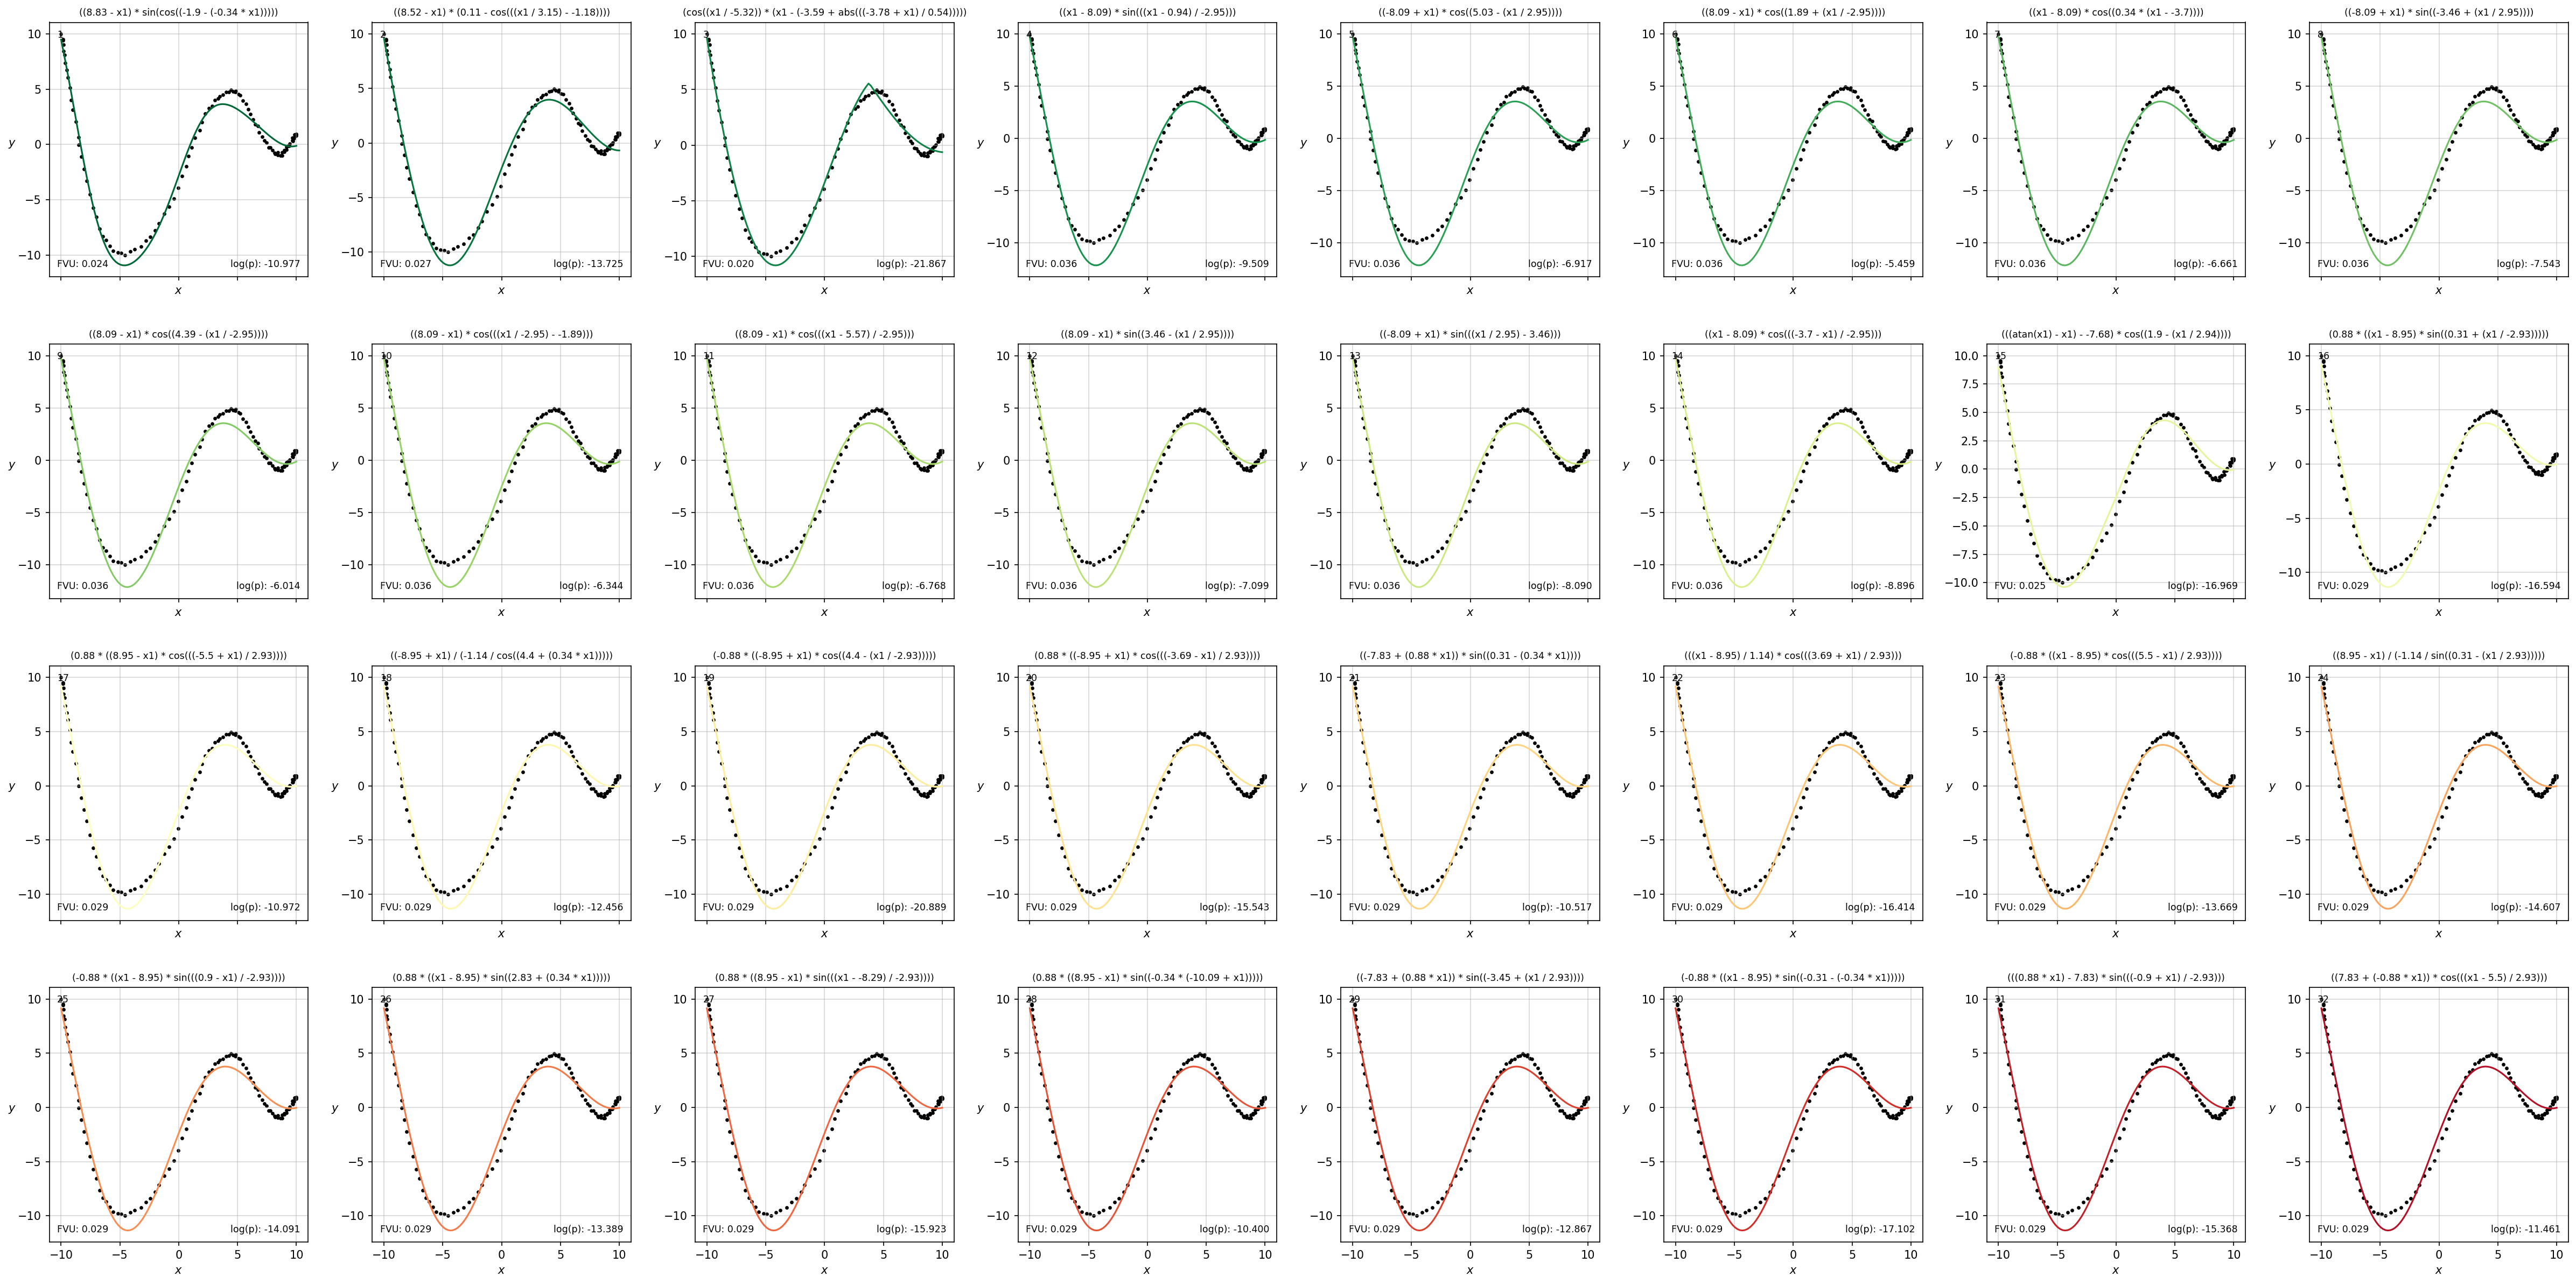

In [27]:
COLS = 8
ROWS = np.ceil(len(y_pred) / COLS).astype(int)

fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4), dpi=150, sharex=True)

for i, ax in enumerate(axs.flat):
    if i >= len(y_pred) or len(y_pred[i]) == 0:
        ax.axis('off')
        continue
    fvu = np.mean((y_pred[i][0][:, 0] - y)**2) / np.var(y)
    expression_pred_transformed = nsr._results[i]['refiner'].transform(nsr._results[i]['expression'], 0, return_prefix=True)
    expression_pred_transformed_infix = nsr.simplipy_engine.prefix_to_infix(expression_pred_transformed, power='**')

    ax.plot(X_linspace, y_pred_linspace[i][0], color=plt.get_cmap('RdYlGn')(1 - i / len(y_pred)))
    ax.scatter(X, y, color='k', s=5)
    ax.set_title(expression_pred_transformed_infix, fontsize='small')
    
    ax.annotate(f'{i + 1}', xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top', fontsize='small')
    ax.annotate(f'FVU: {fvu:.3f}', xy=(0.03, 0.03), xycoords='axes fraction', ha='left', va='bottom', fontsize='small')
    ax.annotate(f'log(p): {nsr._results[i]["log_prob"]:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom', fontsize='small')

    ax.grid(alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$', rotation=0, labelpad=5)

fig.tight_layout(h_pad=3)

Text(0, 0.5, 'Log Probability')

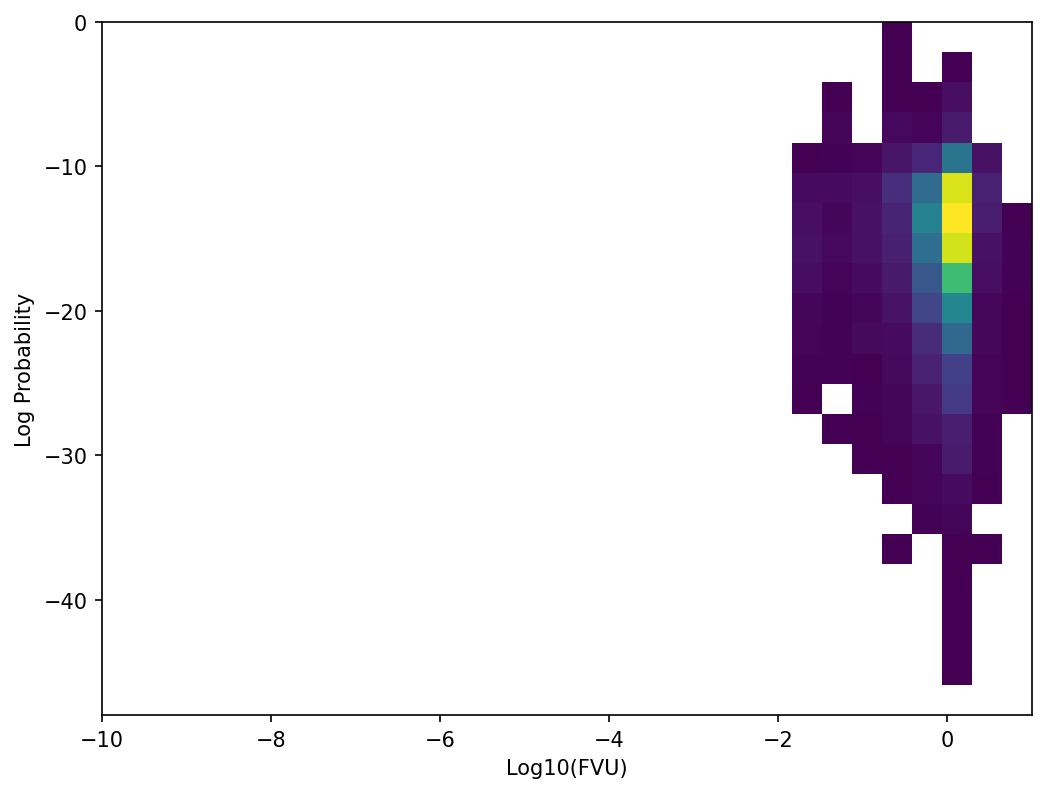

In [16]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.log10(nsr.results['fvu']), nsr.results['log_prob'], bins=(np.linspace(-10, 1, 32), np.linspace(-48, 0, 24)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Log Probability')

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)


Text(0, 0.5, 'Log Probability')

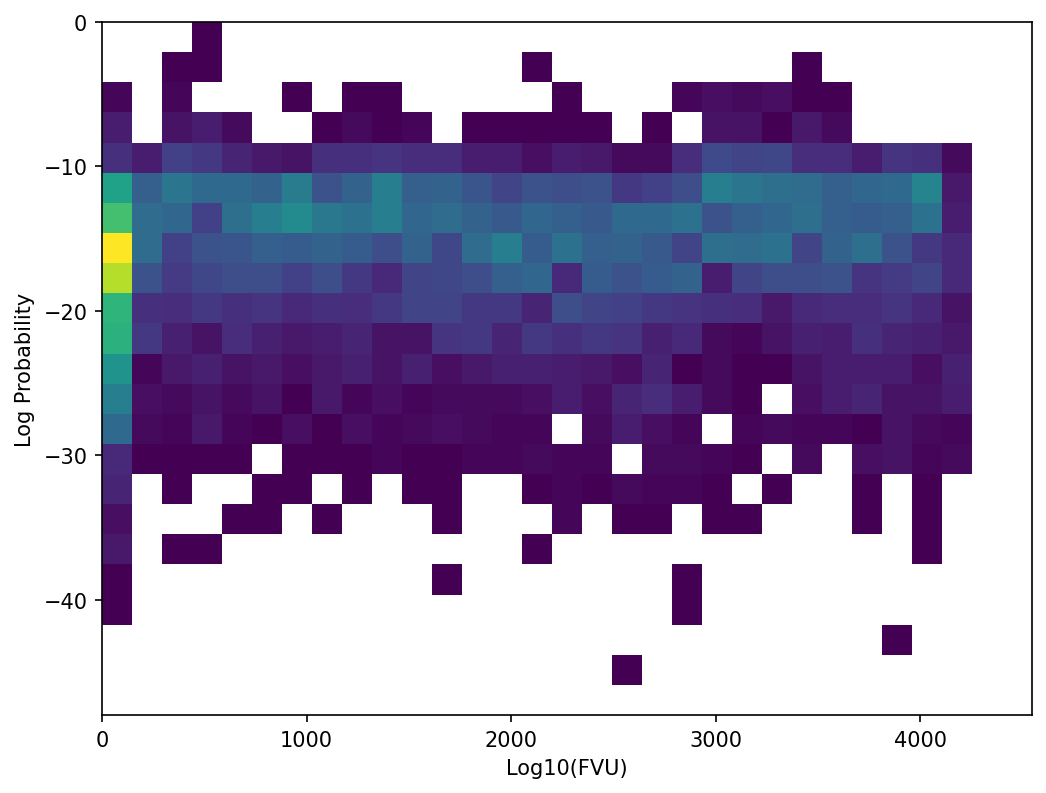

In [17]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.argsort(nsr.results['fvu']), nsr.results['log_prob'], bins=(np.linspace(-1, len(nsr.results), 32), np.linspace(-48, 0, 24)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Log Probability')

Text(0, 0.5, 'Complexity')

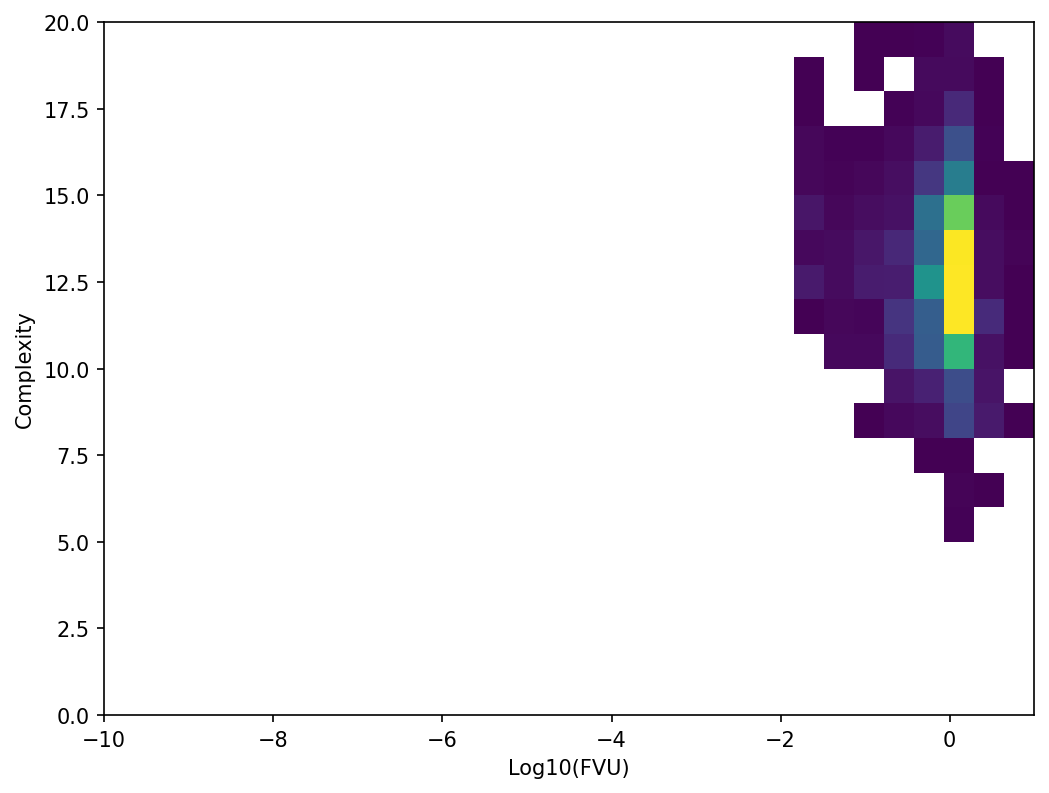

In [18]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.log10(nsr.results['fvu']), nsr.results['complexity'], bins=(np.linspace(-10, 1, 32), np.linspace(0, 20, 21)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Complexity')